In [92]:
import pandas as pd
import numpy as np
from utils.eda import summary
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

In [94]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [95]:
cat_cols = [column for column in train_df.columns if train_df[column].dtype == 'object']
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

num_cols.remove('id')
num_cols.remove('CustomerId')
num_cols.remove('IsActiveMember')
num_cols.remove('HasCrCard')
num_cols.remove('Exited')
cat_cols.remove('Surname')
cat_cols.append('IsActiveMember')
cat_cols.append('HasCrCard')

train_df['HasCrCard'] = train_df['HasCrCard'].astype(bool)
train_df['IsActiveMember'] = train_df['IsActiveMember'].astype(bool)
test_df['HasCrCard'] = test_df['HasCrCard'].astype(bool)
test_df['IsActiveMember'] = test_df['IsActiveMember'].astype(bool)
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,True,False,"181,449.97",0
1,1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,True,True,"49,503.50",0
2,2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,True,False,"184,866.69",0
3,3,15741417,Kao,581,France,Male,34.00,2,"148,882.54",1,True,True,"84,560.88",0
4,4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,True,True,"15,068.83",0


In [96]:
_num_cols = []
no_transform = ['Balance', 'EstimatedSalary', 'CreditScore', 'NumOfProducts', 'Tenure']
for col in num_cols:
    if col in no_transform:
        _num_cols.append(f'{col}')
    else:
        train_df[f'log_{col}'] = np.log1p(train_df[col])
        test_df[f'log_{col}'] = np.log1p(test_df[col])
        _num_cols.append(f'log_{col}')
num_cols = _num_cols

In [97]:
def standardize_features(df, features, method='minmax'):
    # Making a copy of the dataframe to avoid changing the original dataframe
    df_copy = df.copy()

    # Selecting the features to be standardized
    data_to_scale = df_copy[features]

    # Choosing the standardization method
    if method == 'zscore':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid method. Choose from 'zscore', 'minmax', or 'robust'.")

    # Applying the standardization
    standardized_data = scaler.fit_transform(data_to_scale)

    # Replacing the original feature values with the standardized values
    df_copy[features] = standardized_data

    return df_copy

train_df = standardize_features(train_df, num_cols, method = 'robust')
test_df = standardize_features(test_df, num_cols, method = 'robust')

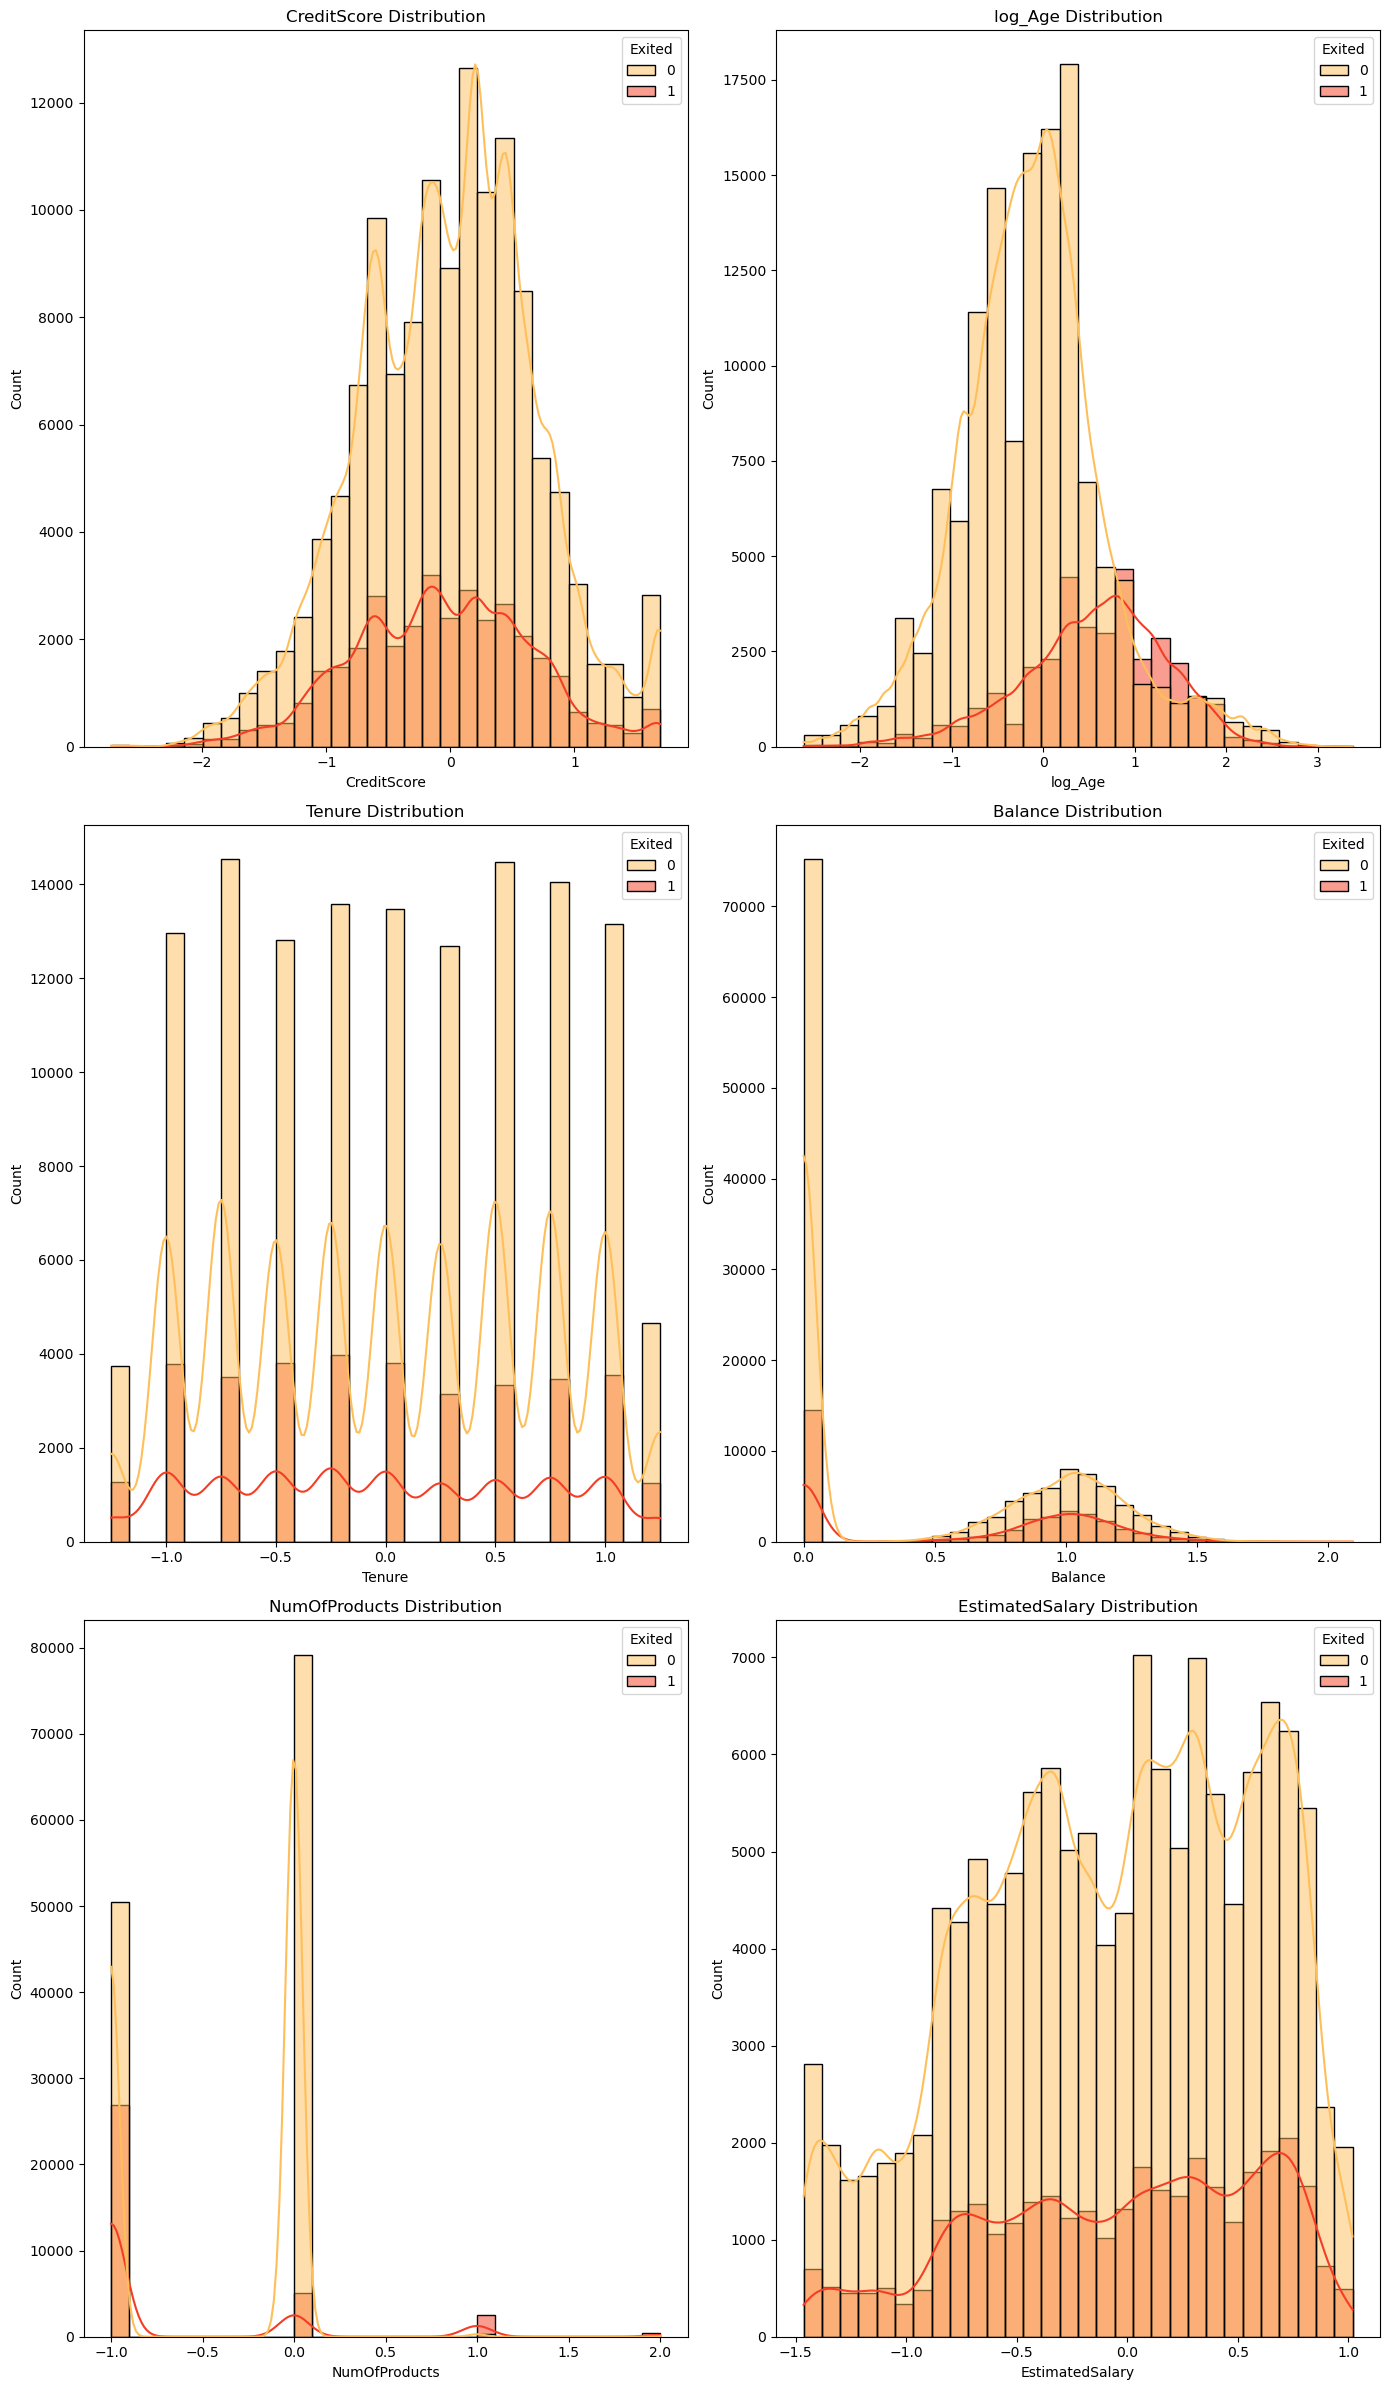

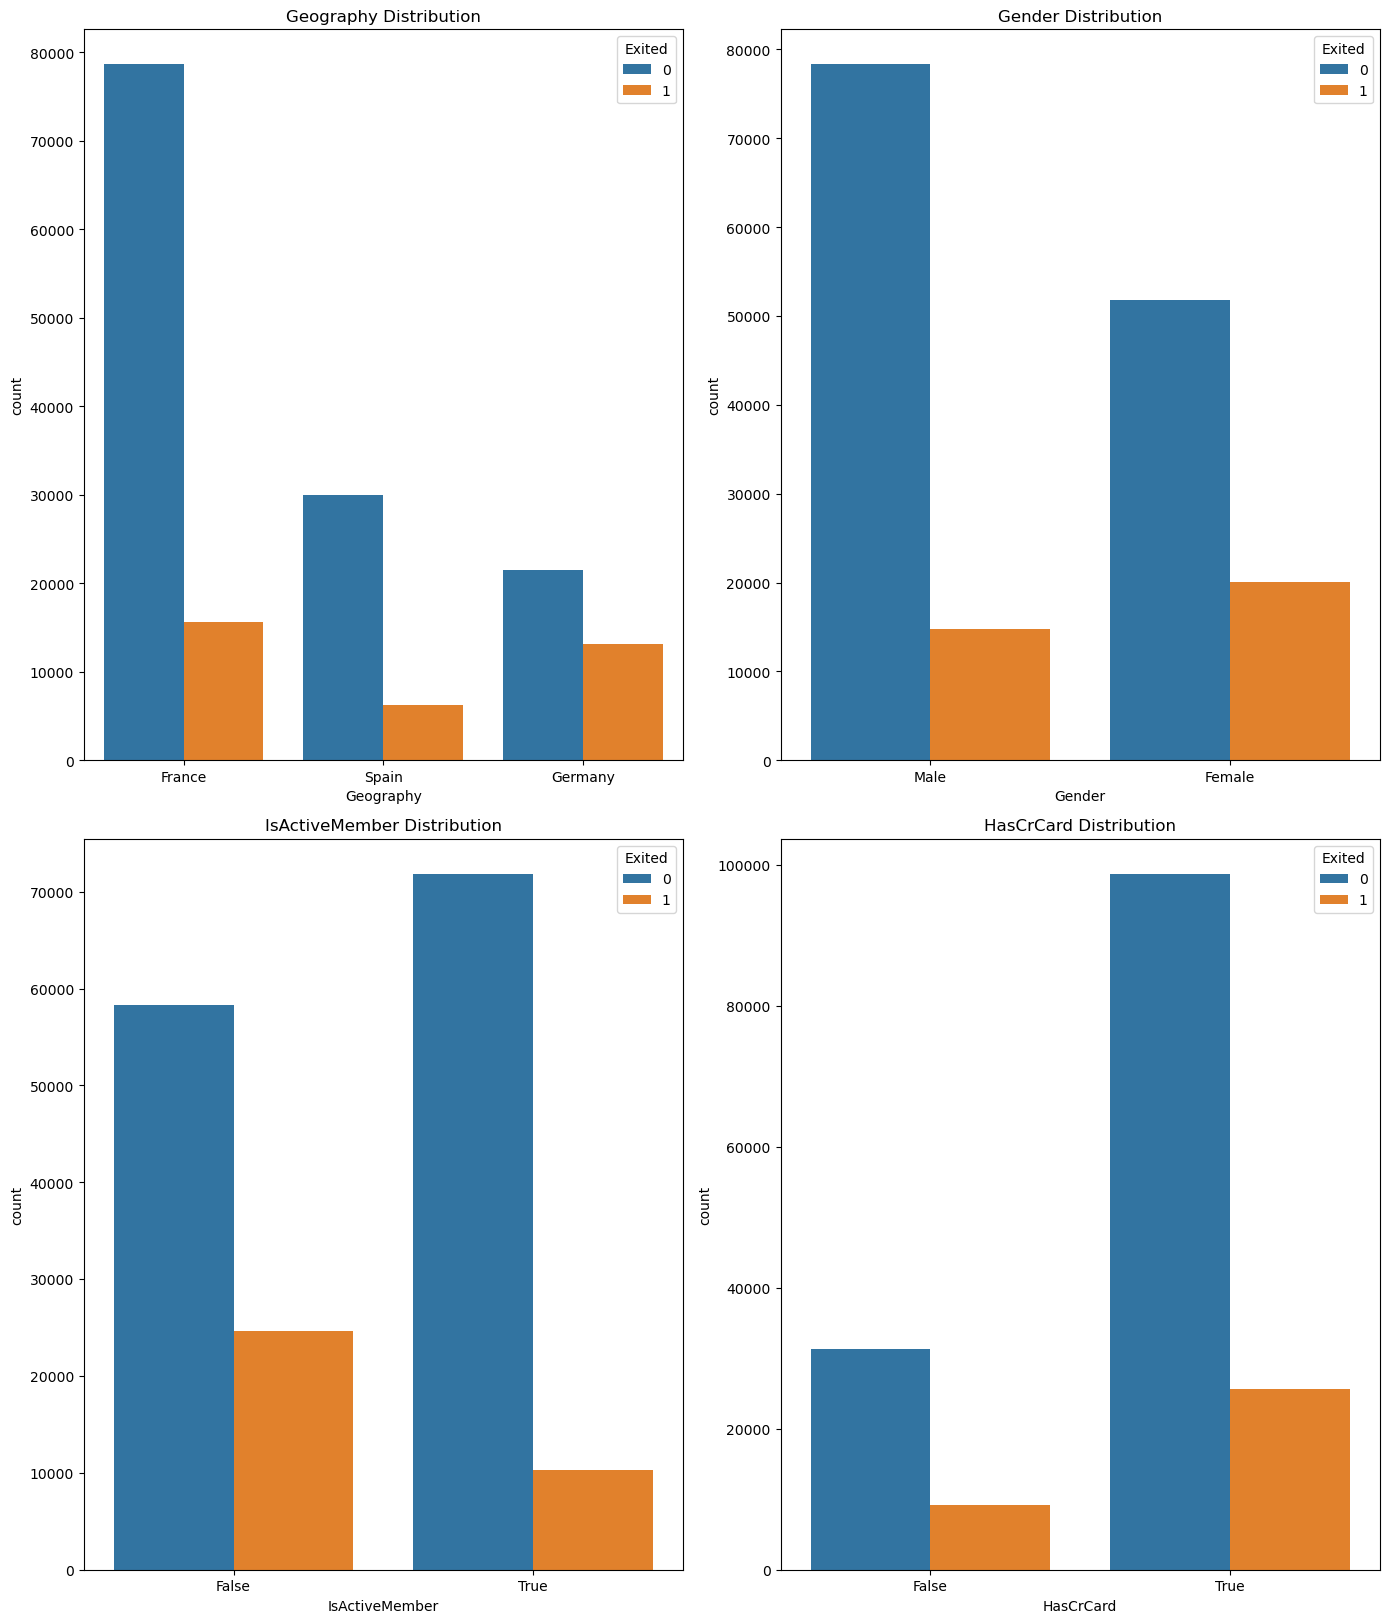

In [98]:
plt.figure(figsize=(14, len(num_cols)*4))

for idx, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//2 + len(num_cols)%2, 2, idx+1)
    sns.histplot(x=col, hue="Exited", data=train_df, bins=30, kde=True, palette='YlOrRd')
    plt.title(f"{col} Distribution")
    plt.tight_layout()
    
plt.show()

plt.figure(figsize=(14, len(num_cols)*4))
for idx, col in enumerate(cat_cols):
    plt.subplot(len(num_cols)//2 + len(num_cols)%2, 2, idx+1)
    sns.countplot(data=train_df, x=col, hue='Exited')
    plt.title(f"{col} Distribution")
    plt.tight_layout()

plt.show()

In [99]:
# Split the data into features (X) and target variable (y)
X = train_df[num_cols+cat_cols]
X_test = test_df[num_cols+cat_cols]
y = train_df['Exited']

# Initialize the CatBoost Classifier
model = CatBoostClassifier(iterations=200,  # Specify the number of boosting iterations
                           depth=6,         # Specify the depth of the trees
                           learning_rate=0.1,  # Specify the learning rate
                           cat_features=cat_cols,
                           eval_metric='AUC',
                           loss_function='Logloss')  # Specify categorical features

# Create a Pool object for CatBoost
pool = Pool(data=X, label=y, cat_features=cat_cols)

# Perform cross-validation
cv_results = cv(pool,
                model.get_params(),
                fold_count=5,  # Number of folds for cross-validation
                verbose=10)  # Set verbose level for progress

# Print cross-validation results
print("Cross-Validation AUC: {:.4f} +/- {:.4f}".format(cv_results['test-AUC-mean'].max(),
                                                       cv_results['test-AUC-std'].max()))


Training on fold [0/5]
0:	test: 0.8677030	best: 0.8677030 (0)	total: 38.5ms	remaining: 7.67s
10:	test: 0.8826485	best: 0.8826485 (10)	total: 317ms	remaining: 5.45s
20:	test: 0.8847553	best: 0.8847553 (20)	total: 578ms	remaining: 4.92s
30:	test: 0.8855699	best: 0.8855699 (30)	total: 925ms	remaining: 5.04s
40:	test: 0.8863005	best: 0.8863005 (40)	total: 1.18s	remaining: 4.57s
50:	test: 0.8867542	best: 0.8867542 (50)	total: 1.46s	remaining: 4.27s
60:	test: 0.8869808	best: 0.8869808 (60)	total: 1.72s	remaining: 3.92s
70:	test: 0.8871647	best: 0.8871647 (70)	total: 1.98s	remaining: 3.59s
80:	test: 0.8873136	best: 0.8873136 (80)	total: 2.23s	remaining: 3.28s
90:	test: 0.8873841	best: 0.8873841 (90)	total: 2.49s	remaining: 2.98s
100:	test: 0.8874582	best: 0.8874582 (100)	total: 2.77s	remaining: 2.71s
110:	test: 0.8874924	best: 0.8875050 (105)	total: 3.04s	remaining: 2.44s
120:	test: 0.8875422	best: 0.8875422 (120)	total: 3.29s	remaining: 2.15s
130:	test: 0.8877127	best: 0.8877127 (130)	total:

In [100]:
model.fit(X,y, cat_features=cat_cols)

0:	total: 42ms	remaining: 8.36s
1:	total: 84.2ms	remaining: 8.34s
2:	total: 109ms	remaining: 7.18s
3:	total: 134ms	remaining: 6.55s
4:	total: 159ms	remaining: 6.2s
5:	total: 188ms	remaining: 6.09s
6:	total: 210ms	remaining: 5.8s
7:	total: 234ms	remaining: 5.62s
8:	total: 263ms	remaining: 5.57s
9:	total: 293ms	remaining: 5.57s
10:	total: 329ms	remaining: 5.65s
11:	total: 358ms	remaining: 5.61s
12:	total: 387ms	remaining: 5.57s
13:	total: 413ms	remaining: 5.49s
14:	total: 453ms	remaining: 5.59s
15:	total: 482ms	remaining: 5.55s
16:	total: 514ms	remaining: 5.53s
17:	total: 540ms	remaining: 5.46s
18:	total: 568ms	remaining: 5.41s
19:	total: 597ms	remaining: 5.37s
20:	total: 619ms	remaining: 5.28s
21:	total: 645ms	remaining: 5.22s
22:	total: 667ms	remaining: 5.13s
23:	total: 695ms	remaining: 5.09s
24:	total: 720ms	remaining: 5.04s
25:	total: 747ms	remaining: 5s
26:	total: 774ms	remaining: 4.96s
27:	total: 802ms	remaining: 4.93s
28:	total: 831ms	remaining: 4.9s
29:	total: 857ms	remaining: 4.

In [101]:
test_pool = Pool(data=X_test, cat_features=cat_cols)

test_probabilities = model.predict_proba(test_pool)
test_preds = model.predict(test_pool)

test_probabilities = test_probabilities[:,1]
test_probabilities

array([0.02465671, 0.83131079, 0.02537488, ..., 0.01911074, 0.14532462,
       0.19001866])

In [102]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['Exited'] = test_probabilities
sub = sub.set_index('id')
sub.head()

,Exited
id,
165034,0.02
165035,0.83
165036,0.03
165037,0.22
165038,0.37


In [103]:
sub.to_csv('submission.csv')